In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movies2csv/movies2.csv
/kaggle/input/wikipedia-movie-plots/wiki_movie_plots_deduped.csv


In [2]:
!pip install sentence-transformers

     |████████████████████████████████| 85 kB 324 kB/s 
     |████████████████████████████████| 4.7 MB 527 kB/s 
     |████████████████████████████████| 101 kB 5.9 MB/s 
     |████████████████████████████████| 6.6 MB 53.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125918 sha256=7d775474ec56f4f670e51493e5b5efe574deaf66ef4f4dc916d617f23b555875
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.2
    Uninstalling tokenizers-0.10.2:
      Successfully uninstalled tokenizers-0.10.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.5.1
    Uninstalling transformers-4.5.1:
      Successfully uninstalled transformers-4.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are 

In [3]:
!nvidia-smi 

Thu Aug 11 21:19:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/115 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/554 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

In [5]:
data = pd.read_csv('../input/movies2csv/movies2.csv',memory_map=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3420 entries, 0 to 3419
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     3420 non-null   int64 
 1   başlık         3420 non-null   object
 2   özet           3420 non-null   object
 3   tür            3420 non-null   object
 4   vizyon_tarihi  3420 non-null   object
 5   oyuncular      3420 non-null   object
 6   yönetmen       3420 non-null   object
 7   resim_link     3420 non-null   object
dtypes: int64(1), object(7)
memory usage: 213.9+ KB


In [6]:
import gc
df = data[['başlık','özet']]
del data
gc.collect()

0

In [7]:
df.dropna(inplace=True)
df.drop_duplicates(subset=['özet'],inplace=True)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


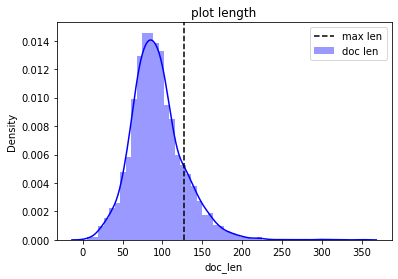

In [8]:
df['doc_len'] = df['özet'].apply(lambda words: len(words.split()))
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
sns.distplot(df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

In [9]:
!pip install faiss-gpu

     |████████████████████████████████| 85.5 MB 135 kB/s 


In [10]:
import faiss
encoded_data = model.encode(df.özet.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(df))))
faiss.write_index(index, 'movie_plot.index')

Batches:   0%|          | 0/107 [00:00<?, ?it/s]

In [11]:
def fetch_movie_info(dataframe_idx):
    info = df.iloc[dataframe_idx]
    meta_dict = {}
    meta_dict['başlık'] = info['başlık']
    return meta_dict
    
def search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_movie_info(idx) for idx in top_k_ids]
    return results

In [12]:
from pprint import pprint

query="Red Andy hapishane suç"
results=search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

>>>> Results in Total Time: 0.04958534240722656


	 {'başlık': 'Esaretin Bedeli'}
	 {'başlık': 'Şahane Hayat'}
	 {'başlık': 'Son Kale'}
	 {'başlık': 'Ölümcül Deney'}
	 {'başlık': 'Sihirli Dadı'}


In [13]:
from pprint import pprint

query="yeşil dev fiona eşek ejderha"
results=search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',(result))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

>>>> Results in Total Time: 0.04368925094604492


	 {'başlık': 'Bitirim İkili 2'}
	 {'başlık': 'Şrek 3'}
	 {'başlık': 'Terminatör 3: Makinelerin Yükselişi'}
	 {'başlık': 'Gizli Gerçekler'}
	 {'başlık': 'İtiraf Ediyorum'}


In [14]:
paragraphs=df.özet.tolist()

In [15]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
tokenizer = T5Tokenizer.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model = T5ForConditionalGeneration.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d

In [16]:
#Select the device
device = 'cuda'
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d

In [17]:
# Parameters for generation
batch_size = 16 #Batch size
num_queries = 5 #Number of queries to generate for every paragraph
max_length_paragraph = 512 #Max length for paragraph
max_length_query = 64   #Max length for output query

In [18]:
def _removeNonAscii(s): return "".join(i for i in s if ord(i) < 128)

In [19]:
# with open('generated_queries_all.tsv', 'w') as fOut:
#     for start_idx in tqdm(range(0, len(paragraphs), batch_size)):
#         sub_paragraphs = paragraphs[start_idx:start_idx+batch_size]
#         inputs = tokenizer.prepare_seq2seq_batch(sub_paragraphs, max_length=max_length_paragraph, truncation=True, return_tensors='pt').to(device)
#         outputs = model.generate(
#             **inputs,
#             max_length=max_length_query,
#             do_sample=True,
#             top_p=0.95,
#             num_return_sequences=num_queries)

#         for idx, out in enumerate(outputs):
#             query = tokenizer.decode(out, skip_special_tokens=True)
#             query = _removeNonAscii(query)
#             para = sub_paragraphs[int(idx/num_queries)]
#             para = _removeNonAscii(para)
#             fOut.write("{}\t{}\n".format(query.replace("\t", " ").strip(), para.replace("\t", " ").strip()))

In [20]:
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets
from torch import nn
import os
import random

train_examples = [] 
with open('../input/movies2csv/movies2.csv') as fIn:
    for line in fIn:
        try:
            query, paragraph = line.strip().split('\t', maxsplit=1)
            train_examples.append(InputExample(texts=[query, paragraph]))
        except:
            pass
        
random.shuffle(train_examples)

# For the MultipleNegativesRankingLoss, it is important
# that the batch does not contain duplicate entries, i.e.
# no two equal queries and no two equal paragraphs.
# To ensure this, we use a special data loader
train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size=8)

# Now we create a SentenceTransformer model from scratch
word_emb = models.Transformer('sentence-transformers/msmarco-distilbert-base-dot-prod-v3')
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_emb, pooling])


# MultipleNegativesRankingLoss requires input pairs (query, relevant_passage)
# and trains the model so that is is suitable for semantic search
train_loss = losses.MultipleNegativesRankingLoss(model)


#Tune the model
num_epochs = 3
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=num_epochs, warmup_steps=warmup_steps, show_progress_bar=True)

os.makedirs('search', exist_ok=True)
model.save('search/search-model')

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration: 0it [00:00, ?it/s]

Iteration: 0it [00:00, ?it/s]

Iteration: 0it [00:00, ?it/s]

In [21]:
from sentence_transformers import SentenceTransformer, util
import gzip
import json
import os

model = SentenceTransformer('search/search-model')

In [22]:
!zip -r search_model.zip "./search"

  adding: search/ (stored 0%)
  adding: search/search-model/ (stored 0%)
  adding: search/search-model/config_sentence_transformers.json (deflated 27%)
  adding: search/search-model/config.json (deflated 44%)
  adding: search/search-model/vocab.txt (deflated 53%)
  adding: search/search-model/tokenizer.json (deflated 71%)
  adding: search/search-model/tokenizer_config.json (deflated 44%)
  adding: search/search-model/pytorch_model.bin (deflated 8%)
  adding: search/search-model/sentence_bert_config.json (deflated 4%)
  adding: search/search-model/1_Pooling/ (stored 0%)
  adding: search/search-model/1_Pooling/config.json (deflated 47%)
  adding: search/search-model/README.md (deflated 58%)
  adding: search/search-model/modules.json (deflated 53%)
  adding: search/search-model/special_tokens_map.json (deflated 42%)


In [23]:
import faiss
encoded_data = model.encode(df.özet.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(df))))
faiss.write_index(index, 'movie_plot.index')

Batches:   0%|          | 0/107 [00:00<?, ?it/s]

In [24]:
from pprint import pprint

query="hırslı balerin kuğu gölü balesi baş dansçı nina"
results=search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

>>>> Results in Total Time: 0.04958081245422363


	 {'başlık': 'Çingeneler Zamanı'}
	 {'başlık': 'Siyah Kuğu'}
	 {'başlık': 'Bir Yaz Gecesi Tebessümleri'}
	 {'başlık': 'Kırmızı Pabuçlar'}
	 {'başlık': 'The Holy Mountain'}


In [25]:
from pprint import pprint

query="korsan johnny depp kaptan jack sparrow"
results=search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

>>>> Results in Total Time: 0.045725345611572266


	 {'başlık': 'Karayip Korsanları: Dünyanın Sonu'}
	 {'başlık': 'Karayip Korsanları Salazar’ın İntikamı'}
	 {'başlık': 'Karayip Korsanları: Gizemli Denizlerde'}
	 {'başlık': 'Dünyanın Uzak Ucu'}
	 {'başlık': 'Ekip 49'}
